In [10]:
# for Google Colab only: Mount my Google Drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [11]:
pwd

'/gdrive'

In [12]:
# for Google Colab only: Navigate to my snaug project folder
cd 'My Drive/Colab Notebooks/snaug'

/gdrive/My Drive/Colab Notebooks/snaug


In [13]:
import sys
print(sys.path)

['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython', '/gdrive/My Drive/Colab Notebooks/snaug/lib']


In [0]:
sys.path.append("/gdrive/My Drive/Colab Notebooks/snaug/lib")
print(sys.path)

['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython', '/gdrive/My Drive/Colab Notebooks/snaug/lib']


In [0]:
#
# Train models on cloud platforms using GPU, then save only the model weights 
# to be reloaded later on machines without powerful GPU.
#

from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

import string
import textwrap
import pickle

from nlplstm_class import (TFModelLSTMCharToken, TFModelLSTMWordToken, 
                               TFModelLSTMWord2vec) 
from data_common import (load_doc, save_doc, clean_doc, prepare_char_tokens)
from data_common import (build_token_lines, prepare_text_tokens, load_word2vec)

In [0]:
pathfinder_textfile = './data/textgen_pathfinder.txt'
fixed_length_token_textfile = './data/pathfinder_fixed-length_tokens.txt'

# 
# Loading, saving and pre-processing of the text data source for 
# character tokenisation
#
# load document
text = load_doc(pathfinder_textfile).lower()

In [17]:
# tokenize character data and separate into features and target for LSTM training
maxlen = 40
step = 3
X, y, char2indices, indices2char, num_unique_char = prepare_char_tokens(text, maxlen, step)

corpus length: 76633
total chars: 57
number of sequences: 25531
number of next_chars: 25531


In [0]:
# save the mappings
pickle.dump(char2indices, open('./model/pathfinder_chartoken_char2indices.pkl', 'wb'))
pickle.dump(indices2char, open('./model/pathfinder_chartoken_indices2char.pkl', 'wb'))

In [19]:
# create new object that is an LSTM model using character tokenization
# to generate text
textgen_model_1 = TFModelLSTMCharToken(use_gpu=True)

# define and compile the model parameters
textgen_model_1.define(maxlen, num_unique_char)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
# LSTM object sanity check
print(textgen_model_1.model_name)
print(textgen_model_1.have_gpu)
print(textgen_model_1.use_cudadnn)
print(textgen_model_1.model.summary())

Character Tokenisation
True
True
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 40, 512)           1169408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 512)           0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 512)               2101248   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 57)                29241     
_________________________________________________________________
activation_1 (Activation)    (None, 57)                0         
Total params: 3,299,897
Trainable params: 3,299,897
Non-trainable params: 0
___________

In [21]:
# compile model
textgen_model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = textgen_model_1.fit(X, y, batch_size=128, epochs=50)
#history = textgen_model_1.fit(X, y, batch_size=128, epochs=2)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/50





25531/25531 [==============================] - 23s 917us/step - loss: 2.9275 - acc: 0.1941
Epoch 2/50
25531/25531 [==============================] - 17s 658us/step - loss: 2.4543 - acc: 0.3081
Epoch 3/50
25531/25531 [==============================] - 17s 663us/step - loss: 2.2642 - acc: 0.3475
Epoch 4/50
25531/25531 [==============================] - 17s 665us/step - loss: 2.1357 - acc: 0.3790
Epoch 5/50
25531/25531 [==============================] - 17s 668us/step - loss: 2.0272 - acc: 0.4035
Epoch 6/50
25531/25531 [==============================] - 17s 671us/step - loss: 1.9262 - acc: 0.4285
Epoch 7/50
25531/25531 [==============================] - 17s 670us/step - loss: 1.8119 - acc: 0.4598
Epoch 8/50
25531/25531 [==============================] - 17s 671us/step - loss: 1.7067 - acc: 0.4871
Epoch 9/50
25531/25531 [==============================] - 17s 671us/step - loss:

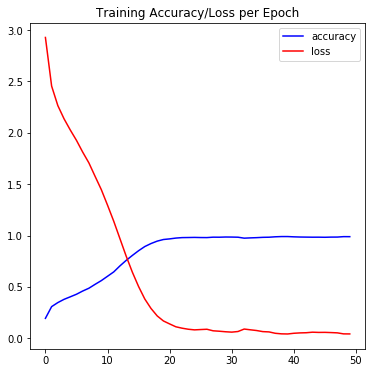

In [22]:
# plot accuracy vs error for training
textgen_model_1.plot_training()

In [0]:
# serialize model weights to HDF5 and save model training history
textgen_model_1.save_weights_and_history(fname_prefix="./model/pathfinder_chartoken_model_50_epoch")